In [13]:
import os
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import mne
from mnelab.io import read_raw
import pynt
from sklearn.model_selection import cross_val_score
from scipy.io import loadmat
from scipy.signal import resample
import seaborn
seaborn.set_context("paper") 
from mne.bem import fit_sphere_to_headshape 
from scipy import interpolate
from scipy.interpolate import griddata

Accuracy for block 1: avg=93.8 with std=6.25
Accuracy for block 2: avg=6.2 with std=10.83
Accuracy for block 3: avg=87.5 with std=15.31
Accuracy for block 4: avg=90.6 with std=10.36
Accuracy for block 5: avg=100.0 with std=0.00
Accuracy for block 6: avg=100.0 with std=0.00
Accuracy for block 7: avg=6.2 with std=6.25


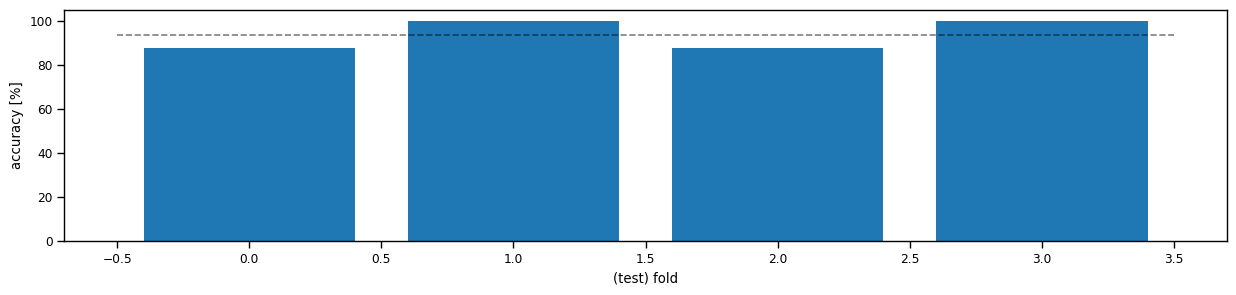

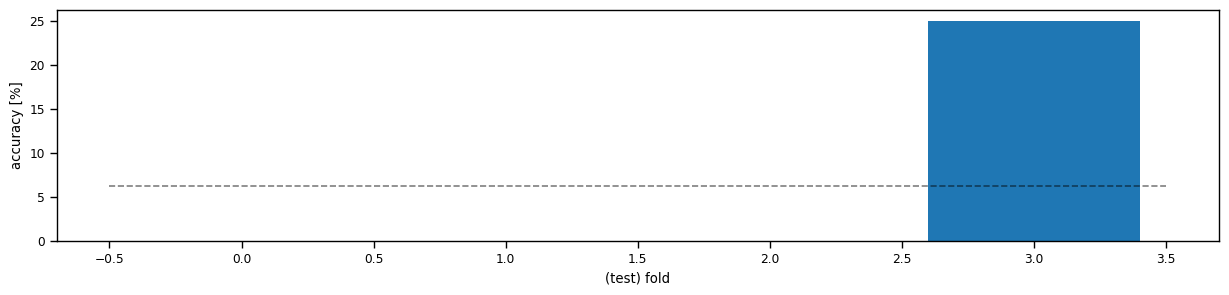

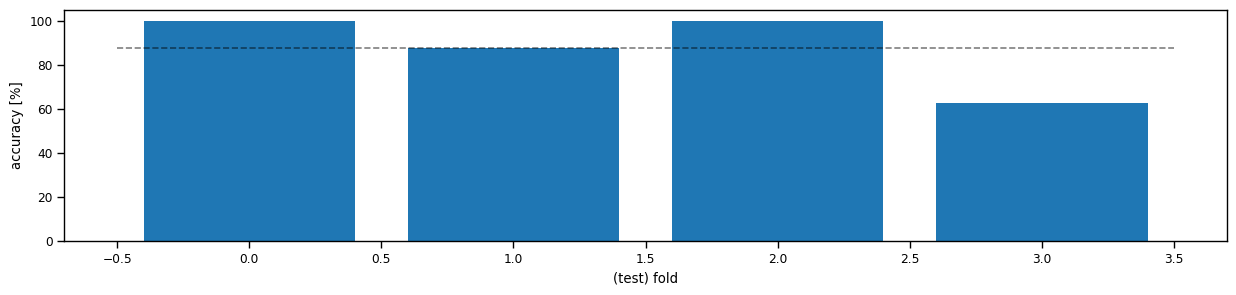

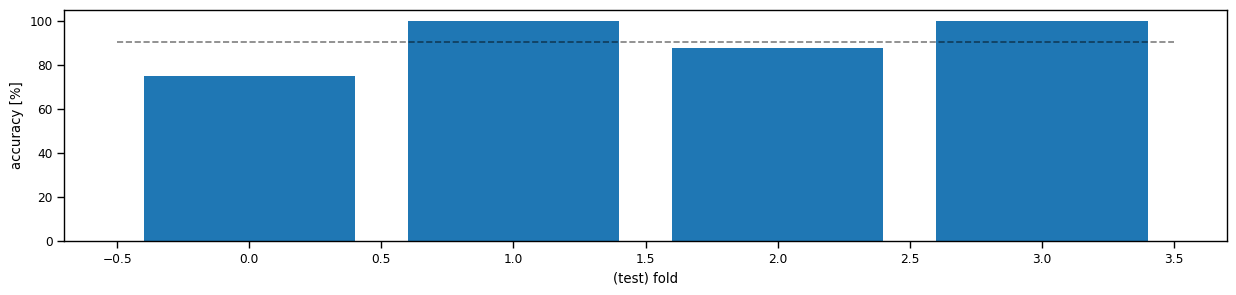

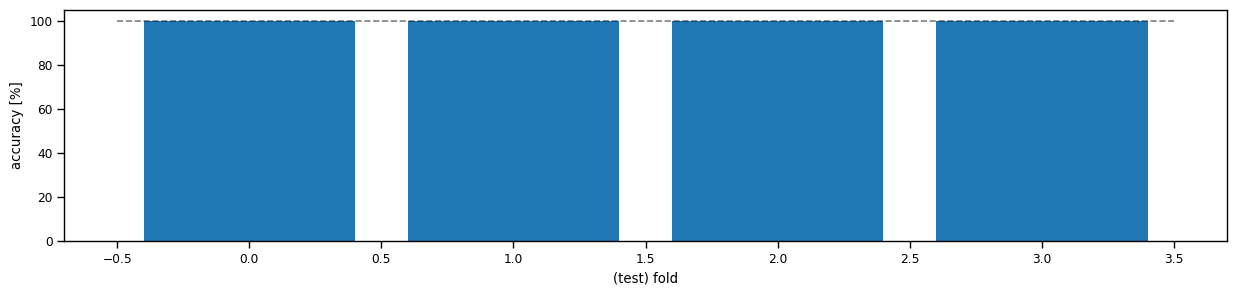

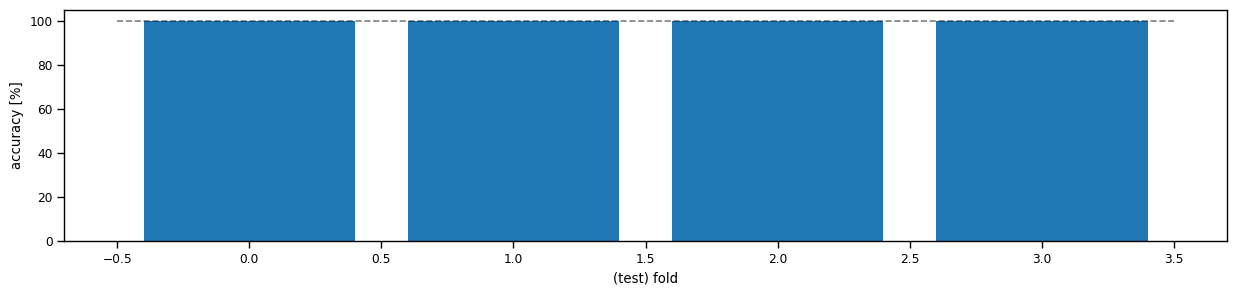

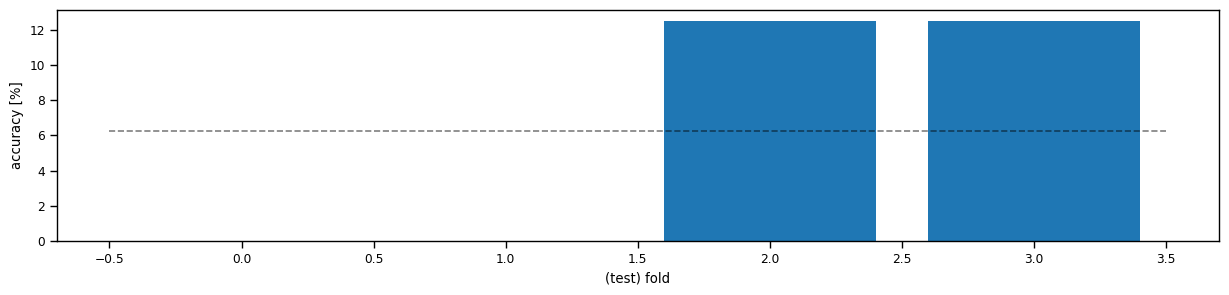

In [15]:
path = "/Users/niluf/BCI_thesis/New_rc/BachelorThesis2324Workspace/s1038443ThesisData/P1Data"
subject = "sub-P001"
trial_time = 4.2

b1 = "1"
b2 = "2"
b3 = "3"
b4 = "4"
b5 = "5"
b6 = "6"
b7 = "7" 

def GettingAccuracyOfTheData(b, subject, path):
    
    # Load data
    data = np.load(os.path.join(path, "derivatives", subject, f"{subject}_{b}.npz"))  
    X = data["X"]
    X = np.transpose(X, (2, 0, 1))
    n_trials, n_channels, n_samples = X.shape
    y = data["y"]
    V = data["V"].T
    fs = data["fs"]

    # Set trial duration
    transient_size = 0.3

    # Setup cross-validation
    n_folds = 4
    folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

    # Loop folds
    accuracy = np.zeros(n_folds)
    for i_fold in range(n_folds):
    
        # Split data into training and validation sets
        X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]
    
        # Train template-matching classifier
        rcca = pynt.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=transient_size, onset_event=True)
        rcca.fit(X_trn, y_trn)
    
        # Apply template-matching classifier
        yh_tst = rcca.predict(X_tst)
        
        # Compute accuracy
        accuracy[i_fold] = 100 * np.mean(yh_tst == y_tst)

    plt.figure(figsize=(15, 3))
    plt.bar(np.arange(n_folds), accuracy)
    plt.hlines(np.mean(accuracy), -.5, n_folds-0.5, linestyle='--', color="k", alpha=0.5)
    plt.xlabel("(test) fold")
    plt.ylabel("accuracy [%]");

    # Print accuracy and standard deviation over folds
    print(f"Accuracy for block {b}: avg={accuracy.mean():.1f} with std={accuracy.std():.2f}")     
     
                  
# Participant - block 1  
GettingAccuracyOfTheData(b1, subject, path)

# Participant - block 2 
GettingAccuracyOfTheData(b2, subject, path)

# Participant - block 3  
GettingAccuracyOfTheData(b3, subject, path)

# Participant - block 4  
GettingAccuracyOfTheData(b4, subject, path)    

# Participant - block 5  
GettingAccuracyOfTheData(b5, subject, path)

# Participant - block 6  
GettingAccuracyOfTheData(b6, subject, path)

# Participant - block 7 
GettingAccuracyOfTheData(b7, subject, path)

Accuracy for between-condition decoding is : avg=60.2 with std=12.38


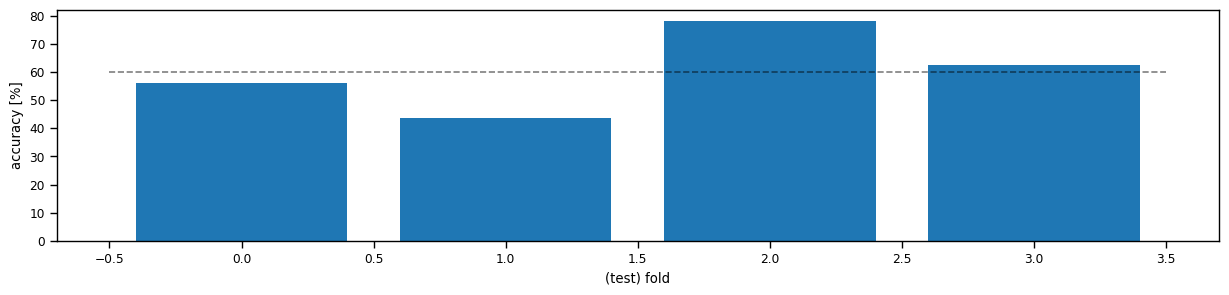

In [16]:
path = "/Users/niluf/BCI_thesis/New_rc/BachelorThesis2324Workspace/s1038443ThesisData/P1Data"
subject = "sub-P001"
trial_time = 4.2
transient_size = 0.3

# Training frequency X1
b1 = "3"  
# Testing frequency X2
b2 = "4"

# Load training data X1
data1 = np.load(os.path.join(path, "derivatives", subject, f"{subject}_{b1}.npz"))  
X1 = data1["X"]
X1 = np.transpose(X1, (2, 0, 1))
n_trials1, n_channels1, n_samples1 = X1.shape
y1 = data1["y"]
V1 = data1["V"].T
fs1 = data1["fs"]

# Load testing data X2
data2 = np.load(os.path.join(path, "derivatives", subject, f"{subject}_{b2}.npz"))  
X2 = data2["X"]
X2 = np.transpose(X2, (2, 0, 1))
n_trials2, n_channels2, n_samples2 = X2.shape
y2 = data2["y"]
V2 = data2["V"].T
fs2 = data2["fs"]

# Setup cross-validation 
n_folds = 4
folds = np.repeat(np.arange(n_folds), int(n_trials1 / n_folds))

# Loop folds
accuracy = np.zeros(n_folds)
for i_fold in range(n_folds):
    
    # Split training data into training sets
    X1_trn, y1_trn = X1[folds != i_fold, :, :n_samples1], y1[folds != i_fold]

    # Train template-matching classifier
    rcca = pynt.classifiers.rCCA(codes=V1, fs=fs1, event="duration", transient_size=transient_size, onset_event=False)
    rcca.fit(X1_trn, y1_trn)
    
    # Setting the codes to the classifier
    rcca.set_codes(V2)
    
    # Apply template-matching classifier
    y_tst_model = rcca.predict(X2)

    # Compute accuracy
    accuracy[i_fold] = 100 * np.mean(y_tst_model == y2)

plt.figure(figsize=(15, 3))
plt.bar(np.arange(n_folds), accuracy)
plt.hlines(np.mean(accuracy), -.5, n_folds-0.5, linestyle='--', color="k", alpha=0.5)
plt.xlabel("(test) fold")
plt.ylabel("accuracy [%]");

# Print accuracy and standard deviation over folds
print(f"Accuracy for between-condition decoding is : avg={accuracy.mean():.1f} with std={accuracy.std():.2f}")